In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd /content/drive/MyDrive/PaperWorks/SCI_Paper1/

/content/drive/.shortcut-targets-by-id/1Xz4dMm4FcduqKVGq1m5my-g-57eJAyRr/PaperWorks/SCI_Paper1


In [2]:
! pip install mtcnn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.2 MB/s 


In [ ]:
# Github Stuff
#!git add *
!git config --global user.email "aashania.antil.phd@gmail.com"
!git config --global user.name "DrAntil"

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   ELBP_Custom_Layers.py
	modified:   OULU_FULLMODEL_With_normalization.ipynb
	modified:   Results/Casia_Intra_NO_LSTM.csv
	new file:   Results/Oulu_P4_NO_LSTM.csv
	new file:   Results/Replay_Intra_NO_LSTM.csv
	modified:   SCI_CrossDataset.ipynb
	modified:   SE_Xception_Model.py
	new file:   __pycache__/ELBP_Custom_Layers.cpython-37.pyc
	modified:   __pycache__/ELBP_Functions.cpython-37.pyc
	new file:   __pycache__/SE_Xception_Model.cpython-37.pyc
	new file:   model_images/ELBP_branch.png
	new file:   model_images/Full_model.png
	new file:   model_images/HSV_branch.png
	new file:   model_images/Replay.png
	new file:   model_images/Squeeze_Xception.png
	new file:   model_images/model_plot.png



In [ ]:
!git add .

In [ ]:
!git 

In [ ]:
!git commit -a -m 'Oulu Retraining, Weight loading fixed'


[master 5676299] Oulu Retraining, Weight loading fixed
 16 files changed, 17595 insertions(+), 12204 deletions(-)
 rewrite OULU_FULLMODEL_With_normalization.ipynb (93%)
 rewrite Results/Casia_Intra_NO_LSTM.csv (96%)
 create mode 100644 Results/Oulu_P4_NO_LSTM.csv
 create mode 100644 Results/Replay_Intra_NO_LSTM.csv
 rewrite SCI_CrossDataset.ipynb (81%)
 create mode 100644 __pycache__/ELBP_Custom_Layers.cpython-37.pyc
 create mode 100644 __pycache__/SE_Xception_Model.cpython-37.pyc
 create mode 100644 model_images/ELBP_branch.png
 create mode 100644 model_images/Full_model.png
 create mode 100644 model_images/HSV_branch.png
 create mode 100644 model_images/Replay.png
 create mode 100644 model_images/Squeeze_Xception.png
 create mode 100644 model_images/model_plot.png


In [ ]:
!git push

Counting objects: 19, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (18/18), done.
Writing objects: 100% (19/19), 1.68 MiB | 5.09 MiB/s, done.
Total 19 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/DrAntil/SCI_Paper1.git
   e14de0e..5676299  master -> master


In [ ]:
    
class HFT(keras.layers.Layer):
    
    def __init__(self, input_dim):
        super(FacePlate, self).__init__()
        self.Faces = tf.Variable(initial_value=tf.zeros(input_dim), trainable=False)
    def get_config(self):

        config = super().get_config().copy()
        return config
    
    def call(self, inputs):
        #print('in Faceplae')
        hs= tf.py_function( getFace,                            [inputs],                           'float32') 
        #print(inputs.shape)
        #print('Faceplate'+str(hs.shape))
        self.Faces=tf.cast(tf.reshape(hs,[-1,100,100,3]), tf.float32)
        return self.Faces
def HFT_F(inp):
    dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(inp))
    frq=fp.ifft2(fp.ifftshift(dark_image_grey_fourier)).real

IndentationError: ignored

In [3]:
from __future__ import print_function
from __future__ import absolute_import



In [4]:
# All helper functions changed to modules in same folder to reduce clutter

# SE model has dense layers 512-64-2
from SE_Xception_Model  import *
from ELBP_Functions     import *
from ELBP_Custom_Layers import *



In [ ]:
def getSavedModel(path_model,images=False):
    loaded_model=SE_Xception()
    inputs_s = keras.Input(shape=(299, 299, 3))
    inputs_s2 = keras.Input(shape=(299, 299, 3))
    print('Slicing model for features')
    X_model= Model(inputs=loaded_model.input, outputs=loaded_model.layers[-3].output,name='Squeeze_Xception')
    if(images):
      model_photu(X_model,name='Squeeze_Xception')
      print('Model image saved to : '+os.getcwd()+'Squeeze_Xception.png')
    print('Done')

    print('Setting Up ELBP branch')
    #common layer to get face data . this will pass the colored cropped face to ELBP and HSV generator
    faceGetter=FacePlate(input_dim=(299,299,1))(inputs_s2)
    #model for ELBP creation
    iLBp=keras.Input(shape=(faceGetter.shape[1],faceGetter.shape[2],faceGetter.shape[3]))
    gray=GrayMaker(input_dim=iLBp.shape)(iLBp)
    ELBP_Full_H=ComputeLBP_full_53(input_dim=gray.shape)(gray)
    ELBP_Full_V=ComputeLBP_full_35(input_dim=gray.shape)(gray)
    ELBP_by04_H=ComputeLBP_4_53   (input_dim=gray.shape)(gray)
    ELBP_by04_V=ComputeLBP_4_35   (input_dim=gray.shape)(gray)
    ELBP_full  =keras.layers.add([ELBP_Full_H,ELBP_Full_V],name='add_ELBP_full')
    ELBP_by04  =keras.layers.add([ELBP_by04_H,ELBP_by04_V],name='add_ELBP_L1')
    ELBP_Concated= keras.layers.concatenate([ELBP_full,ELBP_by04],name='all_lbp_concaterd')
    LBP_container=keras.Model(iLBp,ELBP_Concated,name='ELBP')
    if(images):
      model_photu(LBP_container,name='ELBP_branch')
      print('Model image saved to : '+os.getcwd()+'/model_images/ELBP_branch'.png)

    print('Done')

    print('Setting Up HSV branch')
    V_Chan=V_extractor(input_dim=iLBp.shape)(iLBp)
    V_Chan_ELBP_Full_H = ComputeLBP_full_53(input_dim=V_Chan.shape)(V_Chan)
    V_Chan_ELBP_Full_V = ComputeLBP_full_35(input_dim=V_Chan.shape)(V_Chan)
    V_Chan_ELBP_by04_H = ComputeLBP_4_53   (input_dim=V_Chan.shape)(V_Chan)
    V_Chan_ELBP_by04_V = ComputeLBP_4_35   (input_dim=V_Chan.shape)(V_Chan)
    V_Chan_ELBP_full   = keras.layers.add([V_Chan_ELBP_Full_H,V_Chan_ELBP_Full_V],name='add_V_Chan_ELBP_full')
    V_Chan_ELBP_by04   = keras.layers.add([V_Chan_ELBP_by04_H,V_Chan_ELBP_by04_V],name='add_V_Chan_ELBP_L1')
    V_Chan_ELBP_Concated= keras.layers.concatenate([V_Chan_ELBP_full,V_Chan_ELBP_by04],name='all_V_Concat')
    V_Chan_LBP_container=keras.Model(iLBp,V_Chan_ELBP_Concated,name='V_Channel_ELBP')
    if(images):
      model_photu(LBP_container,name='HSV_branch')
      print('Model image saved to : '+os.getcwd()+'/model_images/HSV_branch'.png)
    print('Done')
    print('Merging Branches')
    x_out=X_model(inputs_s2,training=False)
    ELB_out=LBP_container(faceGetter)
    V_ELB_out=V_Chan_LBP_container(faceGetter)
    el_c=keras.layers.concatenate([ELB_out,V_ELB_out],axis=1,name='lbp_concat')
    concat_all=keras.layers.concatenate([x_out,el_c],axis=1,name='lbp_concaterd')
    concat_all=BatchNormalization()(concat_all)
    p=keras.layers.Dense(256, activation='relu',name='e_dense_1')(concat_all)
    p=keras.layers.Dense(64,activation='relu',name='e_dense_2')(p)
    outputs = keras.layers.Dense(2,activation='sigmoid',name='e_dense_3')(p)
    f_model=keras.Model(inputs_s2,outputs)
    f_model.compile(optimizer='adam', loss='binary_crossentropy',metrics="categorical_accuracy",steps_per_execution=4)
    if(images):
      model_photu(LBP_container,name='Full_model')
      print('Model image saved to : '+os.getcwd()+'/model_images/Full_model'.png)
    print('Done')
    print('Loading weights from model : '+path_model.split('/')[-1])
    t_model=keras.models.load_model(path_model,custom_objects={"getFace1"   :getFace1,
                                                               "getFace"    :getFace,
                                                               "tf_lbp_35_" :tf_lbp_35_,
                                                               "tf_lbp_53_" :tf_lbp_53_,
                                                               "sliceBy4"   :sliceBy4,
                                                               "tf_loader"  :tf_loader}) 
    
    i=0
    for layer in t_model.layers:
        print('                    Loading weights in '+layer.name+'  Output Shape :'+str(layer.output_shape), len(layer.get_weights ()))    
        try:
          f_model.layers[i].set_weights(layer.get_weights())
        except:
          print("                          No weights  ",layer.name)
        i=i+1
        
    print('Loaded '+str(i)+' layers')  
    print('Done')
    f_model.get_layer('Squeeze_Xception').trainable=False
    return f_model    




In [13]:
def getFreshModel(Xweights='Replay',images=False,xception_trainable=False):
    print('Loading xception weights')
    if(Xweights=='Replay'):
      loaded_model=keras.models.load_model('/content/drive/MyDrive/ML_Data/AK Data/xception_REPLAY_squeeze_concat.hdf5')
    if(Xweights=='Casia'):
      
      loaded_model=keras.models.load_model('/content/drive/MyDrive/ML_Data/AK Data/xception_Casia_squeeze_concat.hdf5')
    if(Xweights=='Oulu'):
    
      loaded_model=keras.models.load_model('/content/drive/MyDrive/ML_Data/SavedModels/oulu_squeeze_xception.hdf5')
    else:
      print('Invalid Fresh Weights')
    inputs_s = keras.Input(shape=(299, 299, 3))
    inputs_s2 = keras.Input(shape=(299, 299, 3))
    print('Slicing model for features')
    X_model= Model(inputs=loaded_model.input, outputs=loaded_model.layers[-3].output,name='Squeeze_Xception')
    if(images):
      model_photu(X_model,name='Squeeze_Xception')
      print('Model image saved to : '+os.getcwd()+'Squeeze_Xception.png')
    print('Done')

    print('Setting Up ELBP branch')
    #common layer to get face data . this will pass the colored cropped face to ELBP and HSV generator
    faceGetter=FacePlate(input_dim=(299,299,1))(inputs_s2)
    #model for ELBP creation
    iLBp=keras.Input(shape=(faceGetter.shape[1],faceGetter.shape[2],faceGetter.shape[3]))
    gray=GrayMaker(input_dim=iLBp.shape)(iLBp)
    ELBP_Full_H=ComputeLBP_full_53(input_dim=gray.shape)(gray)
    #ELBP_Full_V=ComputeLBP_full_35(input_dim=gray.shape)(gray)
    ELBP_by04_H=ComputeLBP_4_53   (input_dim=gray.shape)(gray)
    #ELBP_by04_V=ComputeLBP_4_35   (input_dim=gray.shape)(gray)
    ELBP_by16_H=ComputeLBP_16_53  (input_dim=gray.shape)(gray)

    #ELBP_full  =keras.layers.add([ELBP_Full_H,ELBP_Full_V],name='add_ELBP_full')
    #ELBP_by04  =keras.layers.add([ELBP_by04_H,ELBP_by04_V],name='add_ELBP_L1')
    #ELBP_by16  =keras.layers.add([ELBP_by16_H,ELBP_by16_V],name='add_ELBP_L2')

    ELBP_Concated= keras.layers.concatenate([ELBP_Full_H,ELBP_by04_H],name='all_lbp_concaterd')
    LBP_container=keras.Model(iLBp,ELBP_Concated,name='ELBP')
    if(images):
      model_photu(LBP_container,name='ELBP_branch')
      print('Model image saved to : '+os.getcwd()+'/model_images/ELBP_branch.png')

    print('Done')

    print('Setting Up HSV branch')
    V_Chan=V_extractor(input_dim=iLBp.shape)(iLBp)
    V_Chan_ELBP_Full_H = ComputeLBP_full_53(input_dim=V_Chan.shape)(V_Chan)
    #V_Chan_ELBP_Full_V = ComputeLBP_full_35(input_dim=V_Chan.shape)(V_Chan)
    V_Chan_ELBP_by04_H = ComputeLBP_4_53   (input_dim=V_Chan.shape)(V_Chan)
   # V_Chan_ELBP_by04_V = ComputeLBP_4_35   (input_dim=V_Chan.shape)(V_Chan)
    V_Chan_ELBP_by16_H = ComputeLBP_16_53  (input_dim=V_Chan.shape)(V_Chan)
    
    #V_Chan_ELBP_by04   = keras.layers.add([V_Chan_ELBP_by04_H,V_Chan_ELBP_by04_V],name='add_V_Chan_ELBP_L1')
    #V_Chan_ELBP_by16   = keras.layers.add([V_Chan_ELBP_by16_H,V_Chan_ELBP_by16_V],name='add_V_Chan_ELBP_L2')
    
    #V_Chan_ELBP_full   = keras.layers.add([V_Chan_ELBP_Full_H,V_Chan_ELBP_by04_H],name='add_V_Chan_ELBP_full')

    V_Chan_ELBP_Concated= keras.layers.concatenate([V_Chan_ELBP_Full_H,V_Chan_ELBP_by04_H],name='all_V_Concat')
    V_Chan_LBP_container=keras.Model(iLBp,V_Chan_ELBP_Concated,name='V_Channel_ELBP')
    if(images):
      model_photu(LBP_container,name='HSV_branch')
      print('Model image saved to : '+os.getcwd()+'/model_images/HSV_branch.png')
    print('Done')
    print('Merging Branches')
    x_out=X_model(inputs_s2,training=False)
    ELB_out=LBP_container(faceGetter)
    V_ELB_out=V_Chan_LBP_container(faceGetter)
    el_c=keras.layers.concatenate([ELB_out,V_ELB_out],axis=1,name='lbp_concat')
    el_c=keras.layers.Dense(256, activation='relu',name='l_dense_1')(el_c)
    el_c=keras.layers.Dropout(0.2)(el_c)
    concat_all=keras.layers.concatenate([x_out,el_c],axis=1,name='lbp_concaterd')
    concat_all=BatchNormalization()(concat_all)
    p=keras.layers.Dense(512, activation='relu',name='e_dense_1')(concat_all)
    #p=keras.layers.Dropout(0.2)(p)
    p=keras.layers.Dense(64,activation='relu',name='e_dense_2')(p)
    outputs = keras.layers.Dense(2,activation='softmax',name='e_dense_3')(p)

    f_model=keras.Model(inputs_s2,outputs)
    sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.8)
    f_model.compile(optimizer=sgd, loss='binary_crossentropy',metrics="categorical_accuracy",steps_per_execution=4)
    if xception_trainable:
      print('xception sub model is trainable!')
    else  :
      print('xception sub model is NOT trainable!')
    f_model.get_layer('Squeeze_Xception').trainable=xception_trainable
    if(images):
      model_photu(LBP_container,name='Full_model')
      print('Model image saved to : '+os.getcwd()+'/model_images/Full_model.png')
    return f_model    




In [10]:

# Saved Model Paths
OULU_P1_Saved       ='/content/drive/MyDrive/ML_Data/SavedModels/OULU_P1_NOrmaliseAll_256_64_NO_LSTM'
OULU_P2_Saved       ='/content/drive/MyDrive/ML_Data/SavedModels/OULU_P2_NOrmaliseAll_256_64_NO_LSTM'
OULU_P3_Saved       ='/content/drive/MyDrive/ML_Data/SavedModels/OULU_P3_NOrmaliseAll_256_64_NO_LSTM'
OULU_P4_Saved       ='/content/drive/MyDrive/ML_Data/SavedModels/OULU_P4_NOrmaliseAll_256_32_NO_LSTM'
Casia_Saved         ='/content/drive/MyDrive/ML_Data/SavedModels/Casia_XceptFreeze_NOrmaliseAll_256_64_NO_LSTM'
Replay_Saved        ='/content/drive/MyDrive/ML_Data/SavedModels/Repaly_XceptFreeze_NOrmaliseAll_256_64_NO_LSTM'

#Folders
Replay_train_folder = '/content/drive/MyDrive/ML_Data/Datasets_Preprocessed/replay_data_every_10th/train'
Replay_val_folder   = '/content/drive/MyDrive/ML_Data/Datasets_Preprocessed/replay_data_every_10th/dev'
Casia_train_folder  = '/content/drive/MyDrive/ML_Data/Datasets_Preprocessed/casia-fasd-rgb/db_train'
Casia_val_folder    = '/content/drive/MyDrive/ML_Data/Datasets_Preprocessed/casia-fasd-rgb/db_test'
Oulu_train_folder   = '/content/drive/MyDrive/ML_Data/Datasets_Preprocessed/OULU_frames/Train_Files'
Oulu_val_folder     = '/content/drive/MyDrive/ML_Data/Datasets_Preprocessed/OULU_frames/Dev_Files_frames'


replay_test_folder  =  '/content/drive/MyDrive/ML_Data/Datasets_Preprocessed/replay_data_every_10th/test'
casia_test_folder   =  '/content/drive/MyDrive/ML_Data/Datasets_Preprocessed/casia-fasd-rgb/db_test'

#Labels
Replay_train_full   = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/Replay_train_rgb.csv')
Replay_dev_full     = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/Replay_dev_rgb.csv')
Casia_train_full    = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/casia_train.csv')
Casia_dev_full      = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/casia_train.csv')
Oulu_P1_train_full  = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/OULU_Train_Labels_P1.csv')
Oulu_P2_train_full  = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/OULU_Train_Labels_P2.csv')
Oulu_P3_train_full  = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/OULU_Train_Labels_P3.csv')
Oulu_P4_train_full  = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/OULU_Train_Labels_P4.csv')
Oulu_P1_dev_full    = pd.read_csv(  '/content/drive/MyDrive/ML_Data/Labels/OULU_Dev_Labels_P1.csv')
Oulu_P2_dev_full    = pd.read_csv(  '/content/drive/MyDrive/ML_Data/Labels/OULU_Dev_Labels_P2.csv')
Oulu_P3_dev_full    = pd.read_csv(  '/content/drive/MyDrive/ML_Data/Labels/OULU_Dev_Labels_P3.csv')
Oulu_P4_dev_full    = pd.read_csv(  '/content/drive/MyDrive/ML_Data/Labels/OULU_Dev_Labels_P4.csv')


#generators
train_gen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
val_gen   = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
test_gen  = ImageDataGenerator(rescale=1./255)


**Training and Validation data setup for Replay**

In [ ]:
# Replay 
train_folder=Replay_train_folder
val_folder=Replay_val_folder

train_full = Replay_train_full
# for half files
train_1=train_full

#.iloc[::2]

dev_full = Replay_dev_full
dev_1=dev_full#.iloc[::3]

train_data_1 = train_gen.flow_from_dataframe(dataframe = train_1,directory = train_folder,  x_col = "filename", y_col = "label",batch_size =16, shuffle = True, class_mode='categorical',target_size = (299,299))
val_data_1   = val_gen.flow_from_dataframe(dataframe = dev_1, directory = val_folder, x_col = 'filename', y_col = 'label',batch_size = 16, shuffle = False, class_mode= 'categorical',target_size = (299,299))


Found 9150 validated image filenames belonging to 2 classes.
Found 9150 validated image filenames belonging to 2 classes.


**Training and Validation data setup for Casia**

In [ ]:
repl=getFreshModel()

Loading xception weights
Invalid Fresh Weights
Slicing model for features
Done
Setting Up ELBP branch
Done
Setting Up HSV branch
Done
Merging Branches
xception sub model is NOT trainable!


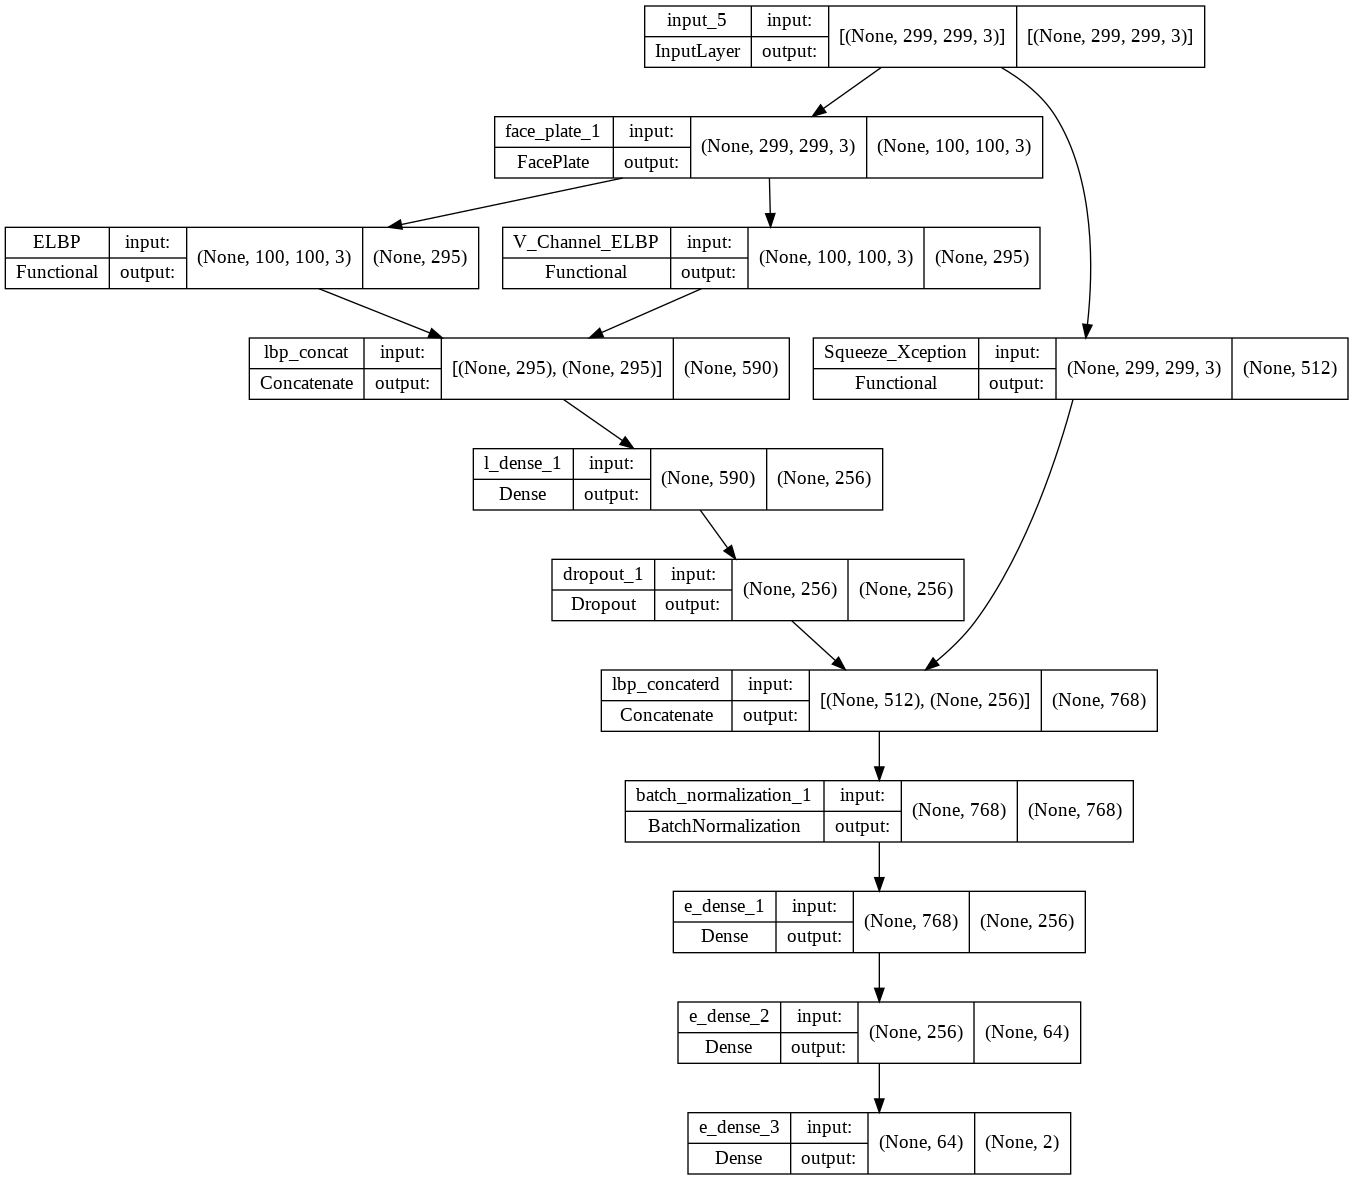

In [ ]:
model_photu(repl,name='altered_')

In [ ]:
repl.fit(train_data_1,epochs=2, validation_data=val_data_1, verbose = 1,use_multiprocessing = True, workers = 4)

Epoch 1/2
572/572 [==============================] - 1053s 2s/step - loss: 0.0453 - categorical_accuracy: 0.9878 - val_loss: 0.0116 - val_categorical_accuracy: 0.9963
Epoch 2/2
572/572 [==============================] - 1006s 2s/step - loss: 0.0149 - categorical_accuracy: 0.9954 - val_loss: 0.0188 - val_categorical_accuracy: 0.9936


In [ ]:
# Casia 
train_folder=Casia_train_folder
val_folder=Casia_val_folder

train_full = Casia_train_full
# for half files
train_1=Casia_dev_full

#.iloc[::2]

dev_full = Casia_dev_full
dev_1=dev_full.iloc[::2]

train_data_1 = train_gen.flow_from_dataframe(dataframe = train_1,directory = train_folder,  x_col = "filename", y_col = "label",batch_size =16, shuffle = True, class_mode='categorical',target_size = (299,299))
val_data_1   = val_gen.flow_from_dataframe(dataframe = dev_1, directory = val_folder, x_col = 'filename', y_col = 'label',batch_size = 16, shuffle = False, class_mode= 'categorical',target_size = (299,299))


Found 8729 validated image filenames belonging to 2 classes.
Found 4365 validated image filenames belonging to 2 classes.


In [ ]:
cas=getFreshModel(Xweights='Casia')

Loading xception weights
Invalid Fresh Weights
Slicing model for features
Done
Setting Up ELBP branch
Done
Setting Up HSV branch
Done
Merging Branches
xception sub model is NOT trainable!


In [ ]:
cas.fit(train_data_1,epochs=2, validation_data=val_data_1, verbose = 1,use_multiprocessing = True, workers = 4)

Epoch 1/2
546/546 [==============================] - 1006s 2s/step - loss: 0.0462 - categorical_accuracy: 0.9845 - val_loss: 0.0052 - val_categorical_accuracy: 0.9989
Epoch 2/2
546/546 [==============================] - 758s 1s/step - loss: 0.0154 - categorical_accuracy: 0.9950 - val_loss: 0.0116 - val_categorical_accuracy: 0.9993


**Training and Validation data setup for Oulu P1**

In [ ]:
# Replay 
train_folder= Oulu_train_folder
val_folder  = Oulu_val_folder

train_full = Oulu_P1_train_full
# for half files
train_1=train_full

#.iloc[::2]

dev_full = Oulu_P1_dev_full
dev_1=dev_full.iloc[::2]

train_data_1 = train_gen.flow_from_dataframe(dataframe = train_1,directory = train_folder,  x_col = "filename", y_col = "label",batch_size =16, shuffle = True, class_mode='categorical',target_size = (299,299))
val_data_1   = val_gen.flow_from_dataframe(dataframe = dev_1, directory = val_folder, x_col = 'filename', y_col = 'label',batch_size = 16, shuffle = False, class_mode= 'categorical',target_size = (299,299))


**Training and Validation data setup for Oulu P2**

In [ ]:
# Replay 
train_folder= Oulu_train_folder
val_folder  = Oulu_val_folder

train_full = Oulu_P2_train_full
# for half files
train_1=train_full

#.iloc[::2]

dev_full = Oulu_P2_dev_full
dev_1=dev_full.iloc[::2]

train_data_1 = train_gen.flow_from_dataframe(dataframe = train_1,directory = train_folder,  x_col = "filename", y_col = "label",batch_size =16, shuffle = True, class_mode='categorical',target_size = (299,299))
val_data_1   = val_gen.flow_from_dataframe(dataframe = dev_1, directory = val_folder, x_col = 'filename', y_col = 'label',batch_size = 16, shuffle = False, class_mode= 'categorical',target_size = (299,299))


**Training and Validation data setup for Oulu P3**

In [ ]:
# Replay 
train_folder= Oulu_train_folder
val_folder  = Oulu_val_folder

train_full = Oulu_P3_train_full
# for half files
train_1=train_full

#.iloc[::2]

dev_full = Oulu_P3_dev_full
dev_1=dev_full.iloc[::2]

train_data_1 = train_gen.flow_from_dataframe(dataframe = train_1,directory = train_folder,  x_col = "filename", y_col = "label",batch_size =16, shuffle = True, class_mode='categorical',target_size = (299,299))
val_data_1   = val_gen.flow_from_dataframe(dataframe = dev_1, directory = val_folder, x_col = 'filename', y_col = 'label',batch_size = 16, shuffle = False, class_mode= 'categorical',target_size = (299,299))


Found 21509 validated image filenames belonging to 2 classes.
Found 8053 validated image filenames belonging to 2 classes.


**Training and Validation data setup for Oulu P4**

In [11]:
# Replay 
train_folder= Oulu_train_folder
val_folder  = Oulu_val_folder

train_full = Oulu_P4_train_full
# for half files
train_1=train_full

#.iloc[::2]

dev_full = Oulu_P4_dev_full
dev_1    = dev_full.iloc[::2]

train_data_1 = train_gen.flow_from_dataframe(dataframe = train_1,directory = train_folder,  x_col = "filename", y_col = "label",batch_size =16, shuffle = True, class_mode='categorical',target_size = (299,299))
val_data_1   = val_gen.flow_from_dataframe(dataframe = dev_1, directory = val_folder, x_col = 'filename', y_col = 'label',batch_size = 16, shuffle = False, class_mode= 'categorical',target_size = (299,299))


Found 6340 validated image filenames belonging to 2 classes.
Found 2379 validated image filenames belonging to 2 classes.


In [14]:
oulu_P4_new=getFreshModel(Xweights='Oulu')

Loading xception weights
Slicing model for features
Done
Setting Up ELBP branch
Done
Setting Up HSV branch
Done
Merging Branches
xception sub model is NOT trainable!


In [7]:
oulu_P4_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 face_plate (FacePlate)         (None, 100, 100, 3)  0           ['input_2[0][0]']                
                                                                                                  
 ELBP (Functional)              (None, 295)          0           ['face_plate[0][0]']             
                                                                                                  
 V_Channel_ELBP (Functional)    (None, 295)          0           ['face_plate[0][0]']         

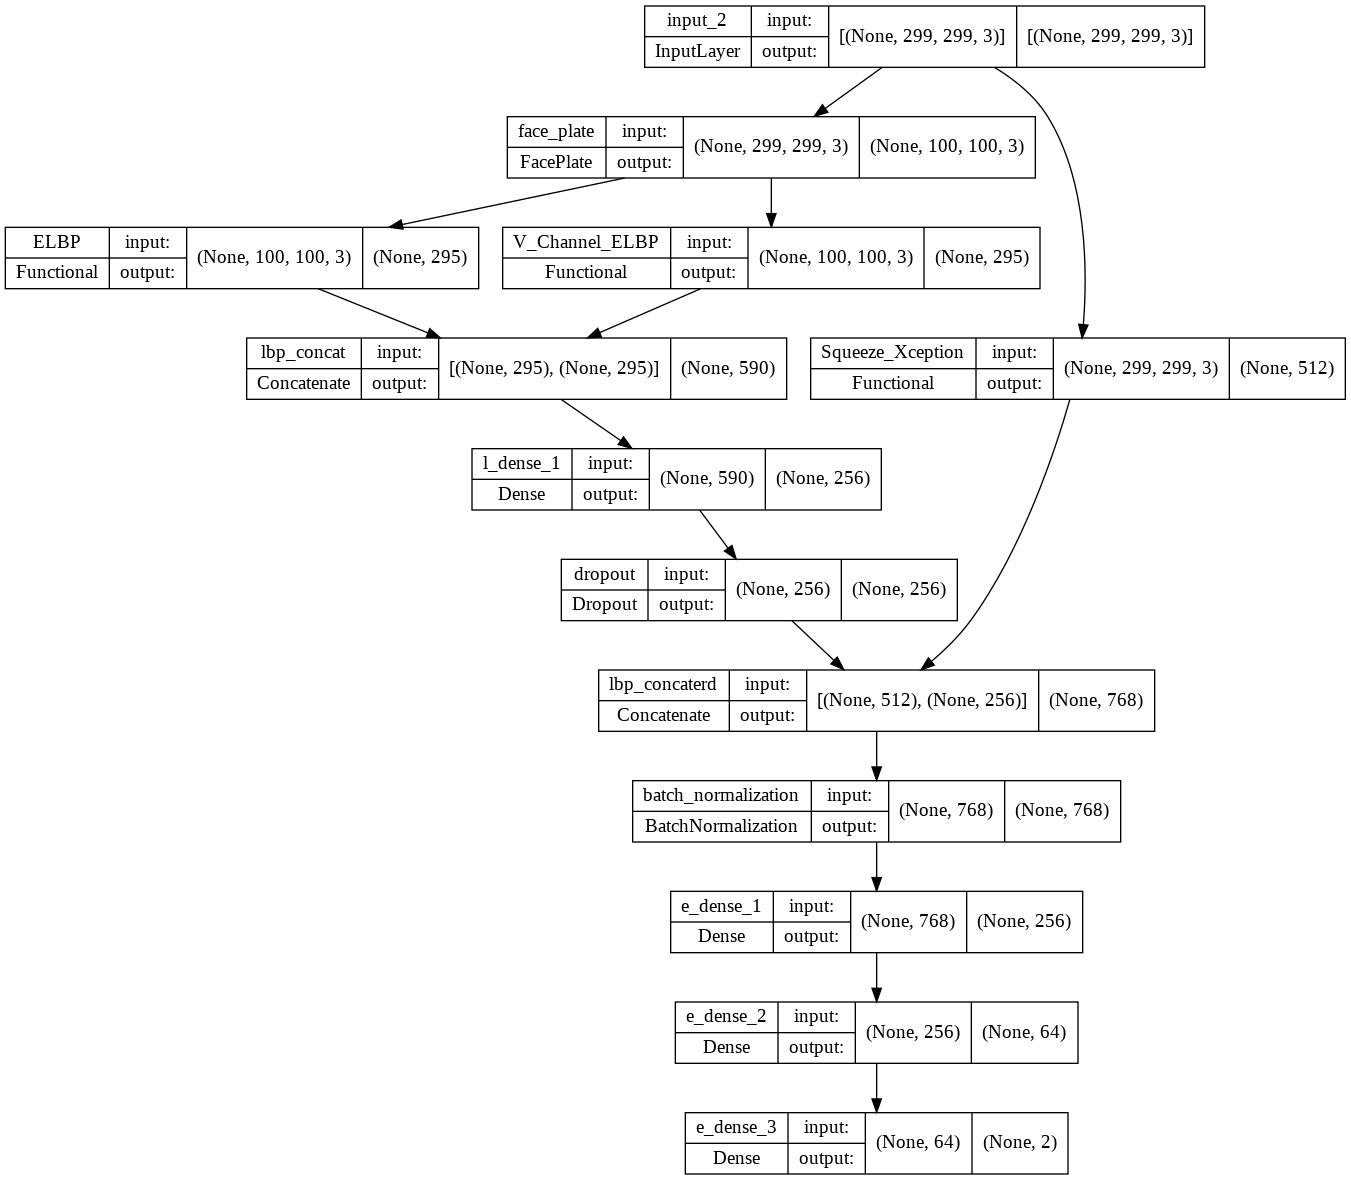

In [9]:
model_photu(oulu_P4_new)

In [ ]:
for l in oulu_P4_new.get_layer('Squeeze_Xception').layers[:-1]:
  l.trainable=False

In [15]:
oulu_P4_new.get_layer('Squeeze_Xception').trainable=True

In [16]:
oulu_P4_new.fit(train_data_1,epochs=1, validation_data=val_data_1, verbose = 1,use_multiprocessing = True, workers = 4)


397/397 [==============================] - 770s 2s/step - loss: 0.1783 - categorical_accuracy: 0.9289 - val_loss: nan - val_categorical_accuracy: 0.7982


In [ ]:
oulu_P4_new.save(OULU_P4_Saved)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_Data/SavedModels/OULU_P4_NOrmaliseAll_256_32_NO_LSTM/assets


In [ ]:
casia_test_set = test_gen.flow_from_directory(casia_test_folder,
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=False)


Found 3885 images belonging to 2 classes.
Found 12200 images belonging to 2 classes.


In [ ]:
repl.save('/content/drive/MyDrive/ML_Data/SavedModels/Repaly_Full_Feature_256_64')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_Data/SavedModels/Repaly_Full_Feature_256_64/assets


In [ ]:

test_full = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/Replay_Test_rgb.csv')
test_full=test_full[::2]
replay_test_set = test_gen.flow_from_dataframe(dataframe =test_full,directory = replay_test_folder,  x_col = "filename", y_col = "label",batch_size =16, shuffle = True, class_mode='categorical',target_size = (299,299))


Found 6100 validated image filenames belonging to 2 classes.


In [ ]:
# Replay Intra test

preds=repl.predict(replay_test_set,  verbose = 1, use_multiprocessing = True, workers = 4)
DF = pd.DataFrame(preds)
DF['filename'] =replay_test_set.filenames
DF['labels_orig']=replay_test_set.labels 
# save the dataframe as a csv file

382/382 [==============================] - 357s 936ms/step


In [ ]:
DF.to_csv("/content/drive/MyDrive/PaperWorks/SCI_Paper1/Results/Replay_Intra_full_feature2_densed.csv")

DF

,0,1,filename,labels_orig
0,1.000000e+00,1.016385e-09,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
1,9.999998e-01,2.312341e-07,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
2,2.119912e-09,1.000000e+00,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
3,1.000000e+00,8.110865e-11,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
4,1.000000e+00,5.781348e-11,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
...,...,...,...,...
6095,9.999971e-01,2.834726e-06,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
6096,1.000000e+00,2.826894e-08,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
6097,1.000000e+00,7.614964e-11,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
6098,1.894527e-08,1.000000e+00,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1


In [ ]:
f_model=getSavedModel(Replay_Saved)

Slicing model for features
Done
Setting Up ELBP branch
Done
Setting Up HSV branch
Done
Merging Branches
Done
Loading weights from model : Repaly_NOrmaliseAll_256_64_NO_LSTM
                    Loading weights in input_6  Output Shape :[(None, 299, 299, 3)] 0
                    Loading weights in face_plate_1  Output Shape :(None, 100, 100, 3) 1
                          No weights   face_plate_1
                    Loading weights in ELBP  Output Shape :(None, 40) 5
                          No weights   ELBP
                    Loading weights in V_Channel_ELBP  Output Shape :(None, 40) 5
                          No weights   V_Channel_ELBP
                    Loading weights in Squeeze_Xception  Output Shape :(None, 512) 242
                    Loading weights in lbp_concat  Output Shape :(None, 80) 0
                    Loading weights in lbp_concaterd  Output Shape :(None, 592) 0
                    Loading weights in batch_normalization_5  Output Shape :(None, 592) 4
           

In [ ]:
test_full = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/casia_test.csv')
test_full=test_full[::2]
cas_test_set = test_gen.flow_from_dataframe(dataframe =test_full,directory =casia_test_folder,  x_col = "filename", y_col = "label",batch_size =16, shuffle = True, class_mode='categorical',target_size = (299,299))


Found 1943 validated image filenames belonging to 2 classes.


In [ ]:
# Replay Intra test

preds=cas.predict(cas_test_set,  verbose = 1, use_multiprocessing = True, workers = 4)
DF = pd.DataFrame(preds)
DF['filename'] =cas_test_set.filenames
DF['labels_orig']=cas_test_set.labels 
# save the dataframe as a csv file
DF

122/122 [==============================] - 169s 1s/step


,0,1,filename,labels_orig
0,1.000000e+00,3.943581e-08,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
1,4.457931e-01,5.542069e-01,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
2,6.338809e-08,9.999999e-01,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
3,9.963036e-01,3.696398e-03,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
4,6.076192e-08,9.999999e-01,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
...,...,...,...,...
1938,1.111150e-04,9.998889e-01,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
1939,3.539583e-12,1.000000e+00,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
1940,1.000000e+00,1.000793e-08,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
1941,1.000000e+00,1.681416e-11,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0


In [ ]:
DF.to_csv("/content/drive/MyDrive/PaperWorks/SCI_Paper1/Results/Casia_Intra_full_feature2_densed.csv")

DF

,0,1,filename,labels_orig
0,1.000000e+00,3.943581e-08,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
1,4.457931e-01,5.542069e-01,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
2,6.338809e-08,9.999999e-01,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
3,9.963036e-01,3.696398e-03,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
4,6.076192e-08,9.999999e-01,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,1
...,...,...,...,...
1938,1.111150e-04,9.998889e-01,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
1939,3.539583e-12,1.000000e+00,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
1940,1.000000e+00,1.000793e-08,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
1941,1.000000e+00,1.681416e-11,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0


In [ ]:
DF.to_csv("/content/drive/MyDrive/PaperWorks/SCI_Paper1/Results/Replay_Intra_NO_LSTM.csv")


In [ ]:
DF

In [ ]:
f_model=getFreshModel(Xweights='Replay')

Loading xception weights
Invalid Fresh Weights
Slicing model for features
Done
Setting Up ELBP branch
Done
Setting Up HSV branch
Done
Merging Branches


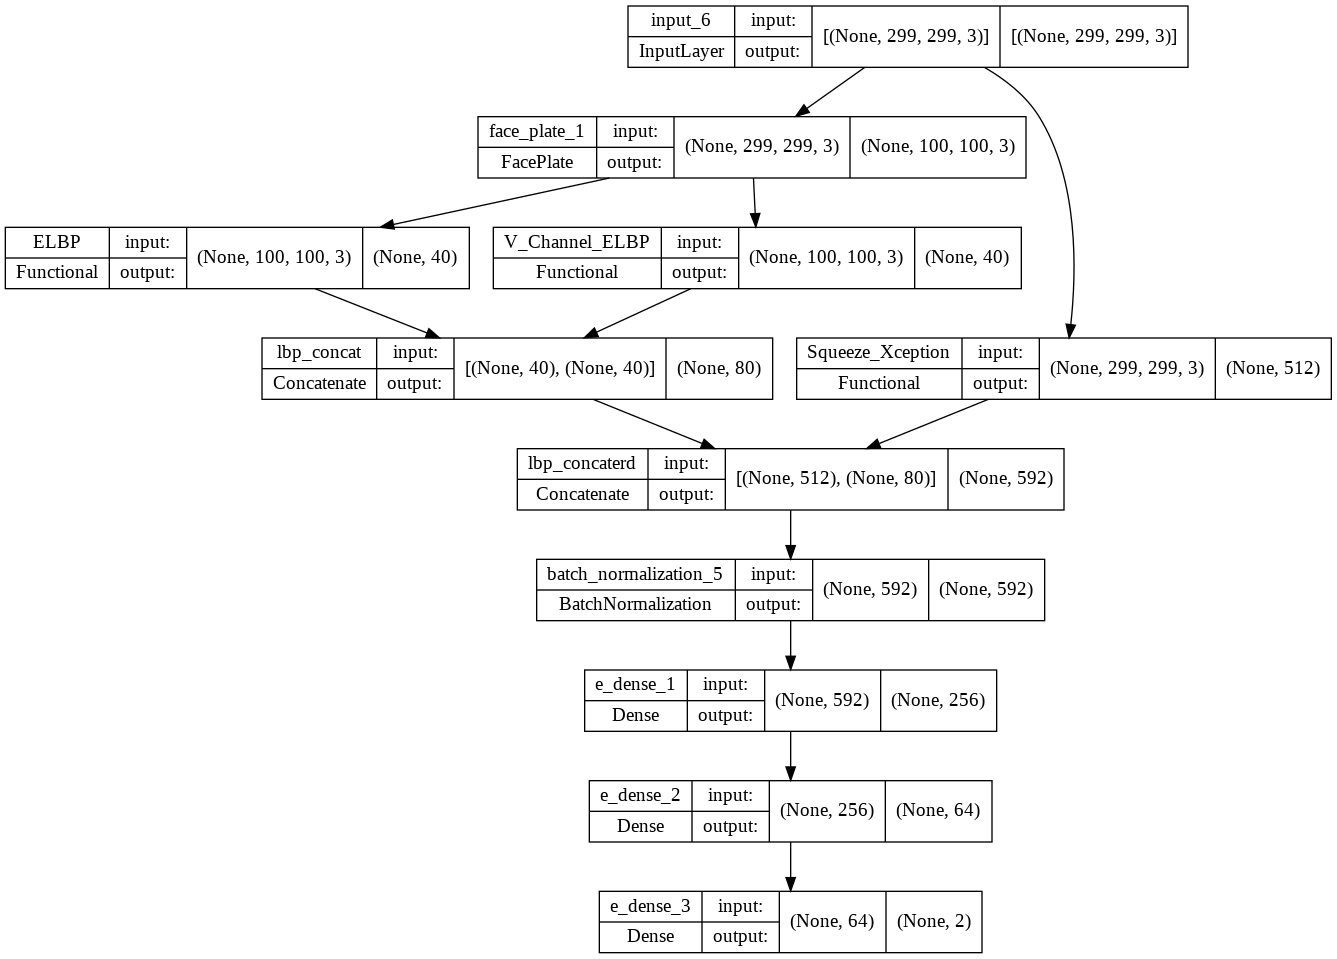

In [ ]:
model_photu(f_model,name='Replay')

In [ ]:
f_model=getSavedModel(OULU_P4_Saved)


83697664/83683744 [==============================] - 2s 0us/step
Slicing model for features
Done
Setting Up ELBP branch
Done
Setting Up HSV branch
Done
Merging Branches
Done
Loading weights from model : OULU_P4_NOrmaliseAll_256_64_NO_LSTM
                    Loading weights in input_2  Output Shape :[(None, 299, 299, 3)] 0
                    Loading weights in face_plate  Output Shape :(None, 100, 100, 3) 1
                          No weights   face_plate
                    Loading weights in ELBP  Output Shape :(None, 40) 5
                          No weights   ELBP
                    Loading weights in V_Channel_ELBP  Output Shape :(None, 40) 5
                          No weights   V_Channel_ELBP
                    Loading weights in Squeeze_Xception  Output Shape :(None, 512) 242
                          No weights   Squeeze_Xception
                    Loading weights in lbp_concat  Output Shape :(None, 80) 0
                    Loading weights in lbp_concaterd  Output Shap

In [ ]:
# Replay Loaded
f_model.fit(train_data_1,epochs=3, validation_data=val_data_1, verbose = 1,use_multiprocessing=True,workers=4)

Epoch 1/3
397/397 [==============================] - 1508s 4s/step - loss: 0.0288 - categorical_accuracy: 0.9899 - val_loss: 1.1737 - val_categorical_accuracy: 0.8558
Epoch 2/3
397/397 [==============================] - 1496s 4s/step - loss: 0.0829 - categorical_accuracy: 0.9719 - val_loss: 2.6950 - val_categorical_accuracy: 0.6129
Epoch 3/3
397/397 [==============================] - 1501s 4s/step - loss: 0.0384 - categorical_accuracy: 0.9864 - val_loss: 120.5369 - val_categorical_accuracy: 0.2135


In [ ]:
f_model.save(OULU_P4_Saved)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_Data/SavedModels/OULU_P4_NOrmaliseAll_256_64_NO_LSTM/assets


Slicing model for features
Done
Setting Up ELBP branch
Done
Setting Up HSV branch
Done
Merging Branches
Done
Loading weights from model : Repaly_NOrmaliseAll_256_64_NO_LSTM
                    Loading weights in input_6  Output Shape :[(None, 299, 299, 3)] 0
                    Loading weights in face_plate_1  Output Shape :(None, 100, 100, 3) 1
                          No weights   face_plate_1
                    Loading weights in ELBP  Output Shape :(None, 40) 5
                          No weights   ELBP
                    Loading weights in V_Channel_ELBP  Output Shape :(None, 40) 5
                          No weights   V_Channel_ELBP
                    Loading weights in Squeeze_Xception  Output Shape :(None, 512) 242
                          No weights   Squeeze_Xception
                    Loading weights in lbp_concat  Output Shape :(None, 80) 0
                    Loading weights in lbp_concaterd  Output Shape :(None, 592) 0
                    Loading weights in batch_

In [ ]:
# replay on casia
test_folder='/content/drive/MyDrive/ML_Data/Datasets_Preprocessed/OULU_frames/Test_Files_frames'
#test_full = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/OULU_Test_Labels_P1.csv')
#test_full = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/OULU_Test_Labels_P2.csv')
#test_full = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/OULU_Test_Labels_P3.csv')
test_full = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/OULU_Test_Labels_P4.csv')
test_gen= ImageDataGenerator(rescale=1./255)

In [ ]:
testData = test_gen.flow_from_dataframe(dataframe =test_full,directory = test_folder,  x_col = "filename", y_col = "label",batch_size =16, shuffle = False, class_mode='categorical',target_size = (299,299))


Found 1300 validated image filenames belonging to 2 classes.


In [ ]:
preds=oulu_P4_new.predict(testData,  verbose = 1, use_multiprocessing = True, workers = 8)



82/82 [==============================] - 88s 1s/step


In [ ]:
DF = pd.DataFrame(preds)
DF['filename'] =testData.filenames
DF['labels_orig']=testData.labels 
DF.to_csv("/content/drive/MyDrive/PaperWorks/SCI_Paper1/Results/Oulu_P4_end_LSTM.csv")

In [ ]:
DF

,0,1,filename,labels_orig
0,NaN,NaN,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
1,NaN,NaN,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
2,NaN,NaN,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
3,NaN,NaN,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
4,NaN,NaN,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
...,...,...,...,...
1295,NaN,NaN,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
1296,NaN,NaN,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
1297,NaN,NaN,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0
1298,NaN,NaN,/content/drive/MyDrive/ML_Data/Datasets_Prepro...,0


In [ ]:
f_model=getSavedModel(OULU_P3_Saved)


Slicing model for features
Done
Setting Up ELBP branch
Done
Setting Up HSV branch
Done
Merging Branches
Done
Loading weights from model : OULU_P3_NOrmaliseAll_256_64_NO_LSTM
                    Loading weights in input_2  Output Shape :[(None, 299, 299, 3)] 0
                    Loading weights in face_plate  Output Shape :(None, 100, 100, 3) 1
                          No weights   face_plate
                    Loading weights in ELBP  Output Shape :(None, 40) 5
                          No weights   ELBP
                    Loading weights in V_Channel_ELBP  Output Shape :(None, 40) 5
                          No weights   V_Channel_ELBP
                    Loading weights in Squeeze_Xception  Output Shape :(None, 512) 242
                    Loading weights in lbp_concat  Output Shape :(None, 80) 0
                    Loading weights in lbp_concaterd  Output Shape :(None, 592) 0
                    Loading weights in batch_normalization  Output Shape :(None, 592) 4
                

In [ ]:
f_model.fit(train_data_1,epochs=3, validation_data=val_data_1, verbose = 1,use_multiprocessing=True,workers=4)


Epoch 1/3
 496/1345 [==========>...................] - ETA: 40:45 - loss: 0.2233 - categorical_accuracy: 0.9165

Process Keras_worker_ForkPoolWorker-97:
Process Keras_worker_ForkPoolWorker-100:
Process Keras_worker_ForkPoolWorker-99:
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-98:
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 11

KeyboardInterrupt: ignored

In [ ]:
f_model.save(OULU_P3_Saved)


In [ ]:

test_full = pd.read_csv('/content/drive/MyDrive/ML_Data/Labels/OULU_Test_Labels_P3.csv')


In [ ]:
testData = test_gen.flow_from_dataframe(dataframe =test_full,directory = test_folder,  x_col = "filename", y_col = "label",batch_size =16, shuffle = False, class_mode='categorical',target_size = (299,299))


In [ ]:
preds=f_model.predict(testData,  verbose = 1, use_multiprocessing = True, workers = 8)
DF = pd.DataFrame(preds)
DF['filename'] =DF = pd.DataFrame(preds)
DF['filename'] =testData.filenames
DF['labels_orig']=testData.labels 
DF.to_csv("/content/drive/MyDrive/PaperWorks/SCI_Paper1/Results/Oulu_P3_NO_LSTM.csv")

In [ ]:
# weight load diagnostics 
t_model=keras.models.load_model(OULU_P3_Saved,custom_objects={"getFace1"   :getFace1,
                                                               "getFace"    :getFace,
                                                               "tf_lbp_35_" :tf_lbp_35_,
                                                               "tf_lbp_53_" :tf_lbp_53_,
                                                               "sliceBy4"   :sliceBy4,
                                                               "tf_loader"  :tf_loader}) 

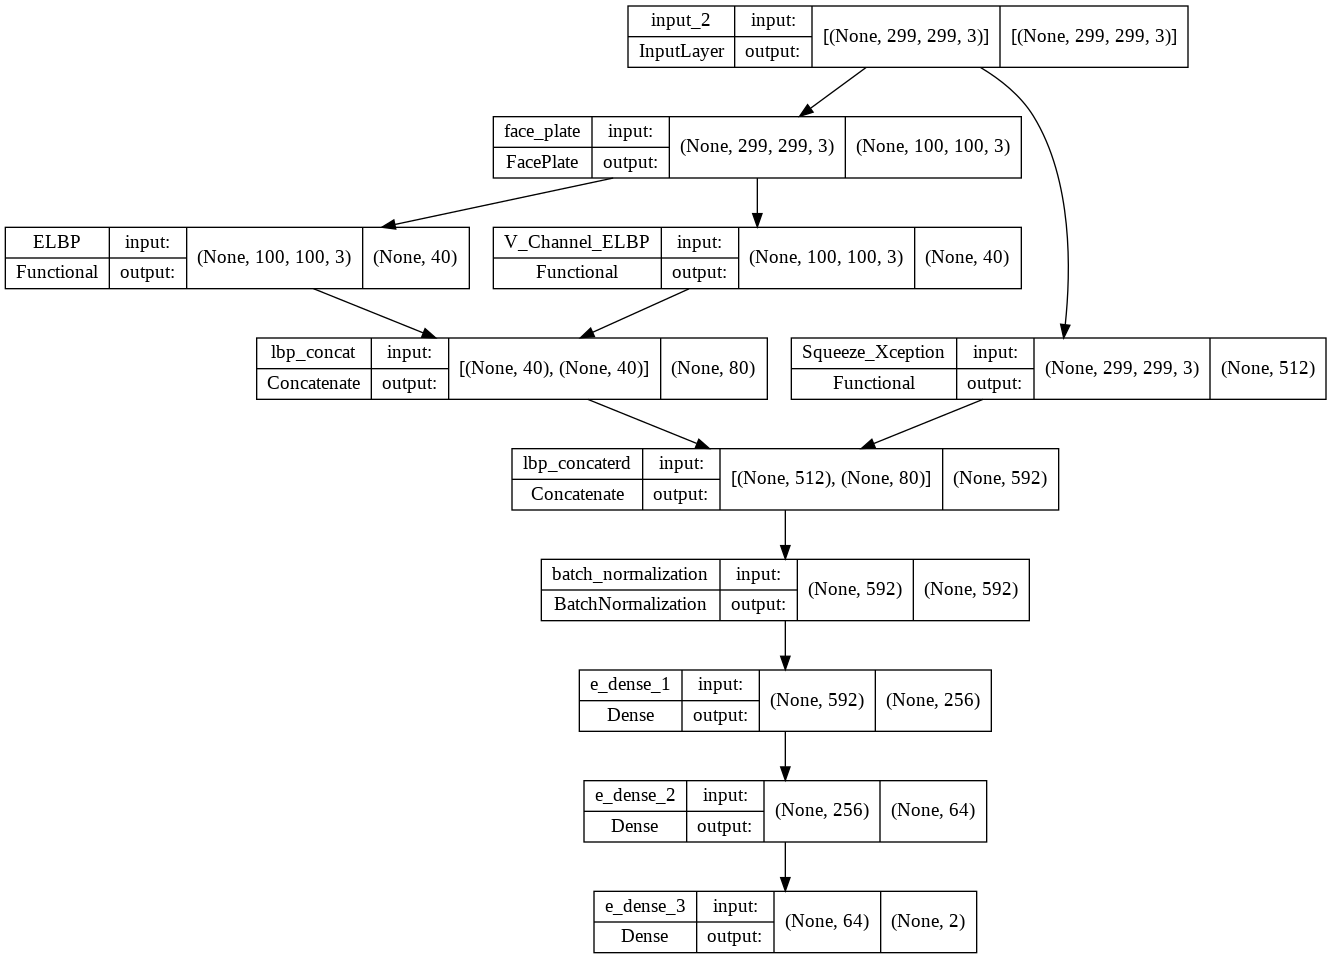

In [ ]:
model_photu(t_model)

In [ ]:
t_model.fit(train_data_1,epochs=3, validation_data=val_data_1, verbose = 1,use_multiprocessing=True,workers=4)

In [ ]:
i=0
for layer in t_model.layers:
        print('                    Loading weights in '+layer.name+'  Output Shape :'+str(layer.output_shape), len(layer.get_weights ()))    
        try:
          f_model.layers[i].set_weights(layer.get_weights())
        except Exception as e: 
          print(e)
          print("                          No weights  ",layer.name)
        i=i+1

                    Loading weights in input_2  Output Shape :[(None, 299, 299, 3)] 0
                    Loading weights in face_plate  Output Shape :(None, 100, 100, 3) 1
You called `set_weights(weights)` on layer "face_plate_1" with a weight list of length 1, but the layer was expecting 0 weights. Provided weights: [array([[[0.],
        [0.],
        [0.],
       ...
                          No weights   face_plate
                    Loading weights in ELBP  Output Shape :(None, 40) 5
You called `set_weights(weights)` on layer "ELBP" with a weight list of length 5, but the layer was expecting 0 weights. Provided weights: [array([[[0.],
        [0.],
        [0.],
       ...
                          No weights   ELBP
                    Loading weights in V_Channel_ELBP  Output Shape :(None, 40) 5
You called `set_weights(weights)` on layer "V_Channel_ELBP" with a weight list of length 5, but the layer was expecting 0 weights. Provided weights: [array([[[0.],
        [0.],
       